In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_files

%matplotlib inline

In [2]:
train_path = 'dataset/train_set'
test_path = 'dataset/test_set'

In [3]:
def load_images_targets(path):
    files = load_files(path)
    filenames = files['filenames']
    targets = files['target']
    return filenames,targets

In [4]:
train_files,train_targets = load_images_targets(train_path)
test_files,test_targets = load_images_targets(test_path)

In [5]:
train_targets.shape,train_files.shape

((7982,), (7982,))

In [6]:
def convert_to_tensors(files,targets):
    lst = []
    for i in range(len(files)):
        file = files[i]
        img = split_into_rgb(file)
        if img.shape == (224,224,3):
            lst.append(img)
        else:
            print(files[i])
    lst = np.array(lst)
    return lst

In [7]:
from scipy.misc import imread, imresize

In [8]:
def split_into_rgb(file):
    img = imread(file)
    img = imresize(img,(224,224,3))
    img = img/255.
    return img


In [9]:
train_tensors = convert_to_tensors(train_files,train_targets)

C:\Users\gowth\Anaconda3\envs\gan\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\gowth\Anaconda3\envs\gan\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
train_tensors.shape

(7982, 224, 224, 3)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train,x_test,y_train,y_test = train_test_split(train_tensors,train_targets,test_size=0.3)

In [13]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(5587, 224, 224, 3) (5587,)
(2395, 224, 224, 3) (2395,)


In [14]:
from keras.utils import to_categorical
def onehot(targets):
    targets = to_categorical(targets)
    return targets

Using TensorFlow backend.


In [15]:
y_train = onehot(y_train)
y_test = onehot(y_test)

In [16]:
print(y_train.shape)
print(y_test.shape)

(5587, 2)
(2395, 2)


In [17]:
def cnn(inputs):
    with tf.variable_scope('cnn',reuse=tf.AUTO_REUSE):
        layer1 = tf.layers.conv2d(inputs=inputs,filters=64,kernel_size=(4,4),padding='same',activation=tf.nn.relu)
        mp1 = tf.layers.max_pooling2d(inputs=layer1,pool_size=(2,2),strides=(2,2),padding='same') #112x112x64
        bn1 = tf.layers.batch_normalization(mp1,training=True)
        
        layer2 = tf.layers.conv2d(inputs=bn1,filters=64,kernel_size=(4,4),padding='same',activation=tf.nn.relu)
        mp2 = tf.layers.max_pooling2d(inputs=layer2,pool_size=(2,2),strides=(2,2),padding='same')
        bn2 = tf.layers.batch_normalization(inputs=mp2,training=True) #56x56x64

        layer3 = tf.layers.conv2d(inputs=bn2,filters=128,kernel_size=(4,4),padding='same',activation=tf.nn.relu)
        mp3 = tf.layers.max_pooling2d(inputs=layer3,pool_size=(2,2),strides=(2,2),padding='same') #28x28x128
        bn3 = tf.layers.batch_normalization(mp3,training=True)
        
        layer4 = tf.layers.conv2d(inputs=bn3,filters=128,kernel_size=(4,4),padding='same',activation=tf.nn.relu)
        mp4 = tf.layers.max_pooling2d(inputs=layer4,pool_size=(2,2),strides=(2,2),padding='same')
        bn4 = tf.layers.batch_normalization(inputs=mp4,training=True) #14x14x128

        layer5 = tf.layers.conv2d(inputs=bn4,filters=256,kernel_size=(4,4),padding='same',activation=tf.nn.relu)
        mp5 = tf.layers.max_pooling2d(inputs=layer5,pool_size=(2,2),strides=(2,2),padding='same') #7x7x256
        bn5 = tf.layers.batch_normalization(mp5,training=True)

        flatten = tf.reshape(bn5,[-1,7*7*256])

        fc1 = tf.layers.dense(inputs=flatten,units=1000,activation=tf.nn.relu) 
        fc1 = tf.layers.dropout(inputs=fc1,rate=0.3)

        fc2 = tf.layers.dense(inputs=fc1,units=200,activation=tf.nn.relu)
        fc2 = tf.layers.dropout(inputs=fc2,rate=0.3)

        logits = tf.layers.dense(inputs=fc2,units=2)
        out = tf.nn.softmax(logits)
    
    return (logits,out)

In [18]:
tf.reset_default_graph()

In [19]:
def model_inputs():
    inputs = tf.placeholder(tf.float32,[None,224,224,3])
    targets = tf.placeholder(tf.float32,[None,2])
    return (inputs,targets)

In [20]:
learning_rate = 0.001
#epochs = 20
batch_size=100

In [21]:
inputs, targets = model_inputs()

In [22]:
logits,out = cnn(inputs)

In [23]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=targets))
correct_pred = tf.cast(tf.equal(tf.argmax(out,1),tf.argmax(targets,1)),tf.float32)
accuracy = tf.reduce_mean(correct_pred)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [63]:
def next_batch(data,batch,batch_size):
    start = batch*batch_size
    end = start+batch_size
    return data[start:end]

In [64]:
from keras.preprocessing.image import ImageDataGenerator

In [65]:
datagen = ImageDataGenerator(featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2)

C:\Users\gowth\Anaconda3\envs\gan\lib\site-packages\keras_preprocessing\image.py:848: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [66]:
datagen.fit(x_train)

In [25]:
saver = tf.train.Saver()

In [68]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #for epoch in range(epochs):
        #for batch in range(len(x_train)//batch_size):
    batch = 0
    for x_batch,y_batch in datagen.flow(x_train,y_train,batch_size=batch_size):
        batch = batch + 1
        #x_batch = next_batch(x_train,batch,batch_size)
        #y_batch = next_batch(y_train,batch,batch_size)

        x_valid = x_test[:100]
        y_valid = y_test[:100]


        sess.run(optimizer,feed_dict={inputs:x_batch,targets:y_batch})


        if batch%10==0:
            loss = sess.run(cost,feed_dict={inputs:x_valid,targets:y_valid})
            acc = sess.run(accuracy,feed_dict={inputs:x_valid,targets:y_valid})
            if acc > 0.9300:
                saver.save(sess,'D:/deep_learning_projects/nikhil/weights/checkpoint_{}.ckpt'.format(batch))
            print('batch {},loss {:.4f},acc {:.4f}'.format(batch,loss,acc))

batch 10,loss 0.3530,acc 0.8300
batch 20,loss 0.4024,acc 0.8500
batch 30,loss 0.9355,acc 0.8100
batch 40,loss 0.6458,acc 0.9300
batch 50,loss 0.5267,acc 0.8800
batch 60,loss 0.4144,acc 0.8900
batch 70,loss 0.1769,acc 0.9300
batch 80,loss 0.1728,acc 0.9400
batch 90,loss 0.2917,acc 0.8900
batch 100,loss 0.2555,acc 0.9100
batch 110,loss 0.2234,acc 0.9300
batch 120,loss 0.2010,acc 0.9300
batch 130,loss 0.2053,acc 0.9100
batch 140,loss 0.1870,acc 0.9300
batch 150,loss 0.1286,acc 0.9700
batch 160,loss 0.2324,acc 0.9000
batch 170,loss 0.1602,acc 0.9300
batch 180,loss 0.1833,acc 0.9400
batch 190,loss 0.1860,acc 0.9300
batch 200,loss 0.2063,acc 0.9200
batch 210,loss 0.1810,acc 0.9300
batch 220,loss 0.1723,acc 0.9500
batch 230,loss 0.1985,acc 0.9400
batch 240,loss 0.1517,acc 0.9300
batch 250,loss 0.1958,acc 0.9400
batch 260,loss 0.2446,acc 0.9100
batch 270,loss 0.1797,acc 0.9200
batch 280,loss 0.1753,acc 0.9200
batch 290,loss 0.1538,acc 0.9400
batch 300,loss 0.1181,acc 0.9300
batch 310,loss 0.13

KeyboardInterrupt: 

In [55]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'D:/deep_learning_projects/nikhil/weights/checkpoint_520.ckpt')
    o = sess.run(accuracy,feed_dict={inputs:x_test[:200],targets:y_test[:200]})
    prediction = sess.run(out,feed_dict={inputs:x_test[1002:1003]})

INFO:tensorflow:Restoring parameters from D:/deep_learning_projects/nikhil/weights/checkpoint_520.ckpt


In [56]:
o

0.945

In [57]:
np.argmax(y_test[1002])

#np.argmax(y_test[1001])

1

In [58]:
np.argmax(prediction)

1

In [59]:
import cv2

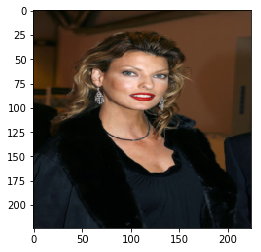

In [63]:
x = x_test[1002]

plt.imshow(x)

In [64]:
l = ['not safe','safe']
l[np.argmax(prediction)]

'safe'